In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fixed_point, root
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from integrated_market_model.market import IntegratedMarketModel

In [2]:
import sys
sys.path.append('../')
from integrated_market_model.market import IntegratedMarketModel
# import sys
 
# adding Folder_2 to the system path
# sys.path.insert(0, '../integrated_market_model')



In [3]:
df = pd.read_csv(f'../data/market_integrates_1.csv')
print(df)


     market_ids  firm_ids  characteristic1  characteristic2    prices  \
0             1         1         2.188926         5.745330  5.453003   
1             1         2         2.402535         5.397174  5.994910   
2             1         3         2.542433         5.762500  5.361356   
3             1         4         2.689597         5.384554  5.891059   
4             1         5         2.185513         5.519165  5.603073   
..          ...       ...              ...              ...       ...   
995         100         6         2.790086         5.613213  4.789455   
996         100         7         2.790538         5.254046  5.487079   
997         100         8         2.410869         5.193101  5.231772   
998         100         9         2.981482         5.553172  4.585670   
999         100        10         2.588651         5.381388  5.245147   

     marginal_cost    shares   profits   markups  e_quantity    capital  \
0         3.847582  0.040712  0.065360  1.417255

In [4]:
# Generate market model at wrong theta 
theta_0 = [1., 1., 1., 1., 1.]
# theta_0 = [2., -0.5, -0.3, 0.5, 1.]

# Frist stage regression some work 

x = df[['marginal_cost', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, df['prices'])

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)

predictions_price = res.predict(x)
df['predict_prices'] = predictions_price



Intercept: 
 -0.36593815113043515
Coefficients: 
 [1.27620824 0.03546657 0.11582994]


In [5]:
# def objective_minimization(theta, n_firms, n_consumers, n_chars, T, s, df, v_p_all):
#     estimation_model = IntegratedMarketModel(
#             n_firms, 
#             n_consumers, 
#             n_chars, 
#             T,
#             beta=np.array(theta[:3]),
#             mu=theta[3],
#             omega=theta[4],
#             seed=s
#         )
    
#     e=0
#     all_estimated_shares = np.zeros(n_firms*T)
#     all_indirect_utilities = np.zeros(n_firms*T)
#     for t in range(0, T):
#         v_p = v_p_all[:,t]
#         # price_period = np.array(df.predict_prices[t*n_firms:(t+1)*n_firms])
#         price_period = np.array(df.prices[t*n_firms:(t+1)*n_firms])
#         estimated_shares, estimated_probabil, indirect_util = estimation_model.compute_share(v_p, price_period, e)
#         all_estimated_shares[t*n_firms:(t+1)*n_firms] = estimated_shares
#         all_indirect_utilities[t*n_firms:(t+1)*n_firms] = indirect_util

#     # return  np.linalg.norm(np.log(df.shares) - np.log(all_estimated_shares))
#     # return linalign.lstsq(np.log)
#     return mean_squared_error(df.shares, all_estimated_shares) 


In [6]:
def objective_minimization(theta, n_firms, n_consumers, n_chars, T, s, df, v_p_all):
    estimation_model = IntegratedMarketModel(
            n_firms, 
            n_consumers, 
            n_chars, 
            T,
            beta1=theta[0],
            beta2=theta[1],
            beta3=theta[2],
            mu=theta[3],
            omega=theta[4],
            seed=s
        )
    
    e=0
    all_estimated_shares = np.zeros(n_firms*T)
    all_indirect_utilities = np.zeros(n_firms*T)
    for t in range(0, T):
        v_p = v_p_all[:,t]
        # price_period = np.array(df.predict_prices[t*n_firms:(t+1)*n_firms])
        price_period = np.array(df.prices[t*n_firms:(t+1)*n_firms])
        estimated_shares, estimated_probabil, indirect_util = estimation_model.compute_share(v_p, price_period, e)
        all_estimated_shares[t*n_firms:(t+1)*n_firms] = estimated_shares
        all_indirect_utilities[t*n_firms:(t+1)*n_firms] = indirect_util

    # return all_indirect_utilities + np.log(df.shares) - np.log(all_estimated_shares)
    return mean_squared_error(df.shares, all_estimated_shares)

In [7]:
n_firms = 4
n_consumers = 1000
n_chars = 2
T = 500
s = 1
v_p_all = np.random.normal(0, 1, (n_consumers, T))
# v_p_all = np.zeros((n_consumers, T))

res = minimize(objective_minimization, theta_0, args=(n_firms, n_consumers, n_chars, T, s, df, v_p_all), method = 'Nelder-Mead' )
    # optim_vec = res.x
print(res)


ValueError: cannot reshape array of size 0 into shape (1,4)

In [ ]:

df2 = df.groupby('market_ids').sum('shares')
outside_good = np.repeat(np.array(df2.shares), n_firms)

# Get outside good same shape datagrame repeat each 10 times 
y = np.log(np.array(df.shares)) - np.log(outside_good)
print(y)


[-1.3630853  -1.2646518  -1.38471967 ... -1.31467234 -1.18413597
 -1.69162622]


In [ ]:
# Easy ols estimation 

# x = df[['prices', 'characteristic1', 'characteristic2']]

# res = LinearRegression().fit(x, y)

# print('Intercept: \n', res.intercept_)
# print('Coefficients: \n', res.coef_)



In [ ]:
# Second stage: 

# x = df[['predict_prices', 'characteristic1', 'characteristic2']]

# res = LinearRegression().fit(x, y)

# print('Intercept: \n', res.intercept_)
# print('Coefficients: \n', res.coef_)



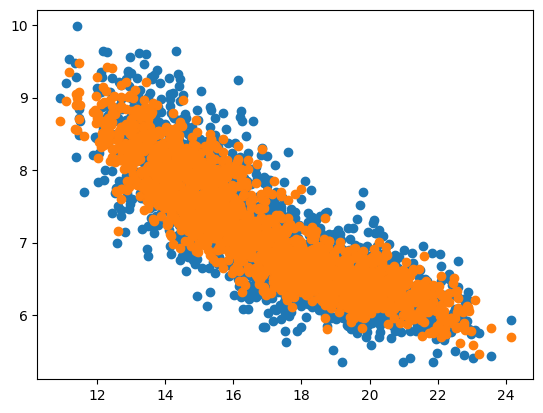

In [ ]:

plt.scatter(df.e_quantity, df.prices)
plt.scatter(df.e_quantity, df.predict_prices)
plt.show()

In [ ]:
# N = 500
# firms  = 5
# time = 100 

# all_val_b0 = []
# all_val_b1 = []
# all_val_b2 = []
# all_val_mu = []
# all_val_omega = []
# mean_share = []

# for l in range(1, 5):
    
#     res = minimize(f, theta_0, args=(df, N, firms, time), method = 'Nelder-Mead')
#     optim_vec = res.x

#     all_val_b0.append(optim_vec[0])
#     all_val_b1.append(optim_vec[1])
#     all_val_b2.append(optim_vec[2])
#     all_val_mu.append(optim_vec[3])
#     all_val_omega.append(optim_vec[4])

#     # new_shares = estimation_functions.shares_optimal(optim_vec, df, v_p, N, firms, time)


# df_estimation_values = pd.DataFrame({'beta_0': all_val_b0,
#                                     'beta_1': all_val_b1,
#                                     'beta_2': all_val_b2, 
#                                     'mu': all_val_mu, 
#                                     'omega': all_val_omega, 
#                                     })
# df_estimation_values.to_csv(f'../data/first_estimation_market_inter_100', index=False)


In [ ]:
# print(df_estimation_values)
# df_estimation_values.to_csv(f'../data/estimation_thetaones.csv', index=False)

In [ ]:
# fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2)
# fig.suptitle(f'Estimation results frist run')

# ax1.hist(df_estimation_values.beta_0, bins=50, color='red')
# ax2.hist(df_estimation_values.beta_1, bins=50, color='orange')
# ax3.hist(df_estimation_values.beta_2, bins=50, color='green')
# ax4.hist(df_estimation_values.mu, bins=50, color='lightblue')
# ax5.hist(df_estimation_values.omega, bins=50, color='pink')
# ax6.hist(df.shares, bins=50)


# ax1.set_title('beta0')
# ax2.set_title('beta1')
# ax3.set_title('beta2')
# ax4.set_title('mu')
# ax5.set_title('omega')
# ax6.set_title('shares')

# plt.tight_layout()
# plt.show()
